In [5]:
from PIL import Image
import os

def get_image_sizes(folder_path):
    image_sizes = {}
    for filename in os.listdir(folder_path):
        if filename.endswith(('.jpg', '.jpeg', '.png', '.gif')):  # 只处理图片文件
            file_path = os.path.join(folder_path, filename)
            with Image.open(file_path) as img:
                width, height = img.size
                image_sizes[filename] = (width, height)
    return image_sizes

folder_path = '/root/dip/#O-HAZY/GT'
sizes = get_image_sizes(folder_path)

for filename, size in sizes.items():
    print(f"Image: {filename}, Size: {size[0]}x{size[1]} pixels")


FileNotFoundError: [Errno 2] No such file or directory: '/root/dip/#O-HAZY/GT'

In [ ]:
# 定义目标尺寸
target_width = 512
target_height = 512

# 打开图像并缩放
def resize_image(image_path):
    img = Image.open(image_path)
    resized_img = img.resize((target_width, target_height), Image.ANTIALIAS)
    return resized_img

# 保存缩放后的图像
def save_resized_image(resized_img, output_path):
    resized_img.save(output_path)

for i in range(1, 46):
    path_gt = '/root/dip/#O-HAZY/GT/' + str(i).zfill(2) + '_outdoor_GT.jpg'
    path_hazy = '/root/dip/#O-HAZY/hazy/' + str(i).zfill(2) + '_outdoor_hazy.jpg'
    if i < 36:
        path_gt_s = '/root/dip/pj/DIP_PJ/DM2F-Net-master/data/O-Haze/train_crop_512/gt/' + str(i).zfill(2) + '_outdoor_GT.jpg'
        path_hazy_s = '/root/dip/pj/DIP_PJ/DM2F-Net-master/data/O-Haze/train_crop_512/hazy/' + str(i).zfill(2) + '_outdoor_hazy.jpg'
    else:
        path_gt_s = '/root/dip/pj/DIP_PJ/DM2F-Net-master/data/O-Haze/val/gt/' + str(i).zfill(2) + '_outdoor_GT.jpg'
        path_hazy_s = '/root/dip/pj/DIP_PJ/DM2F-Net-master/data/O-Haze/val/hazy/' + str(i).zfill(2) + '_outdoor_hazy.jpg'
    
    resized_img_gt = resize_image(path_gt)
    save_resized_image(resized_img_gt, path_gt_s)
    resized_img_hazy = resize_image(path_hazy)
    save_resized_image(resized_img_hazy, path_hazy_s)


# # 示例用法
# input_image_path = 'input_image.jpg'
# output_image_path = 'resized_image.jpg'

# resized_img = resize_image(input_image_path)
# save_resized_image(resized_img, output_image_path)


In [ ]:
from torchvision.transforms import ToTensor
from skimage.metrics import structural_similarity
from skimage.color import deltaE_ciede2000
from PIL import Image
import numpy as np
import cv2

dehaze_path = '/mnt/data/HazeRD/data/img/IMG_8416_RGB.jpg'
gt_path = '/root/DM2F-Net-master/ckpt/RESIDE_ITS/(RESIDE_ITS) HazeRD_iter_4000_loss_0.01767_lr_0.000001/IMG_8416_50.png'
to_tensor = ToTensor()

dehaze = Image.open(dehaze_path).convert('RGB')
#dehaze = Image.open(dehaze_path)
dehaze = np.array(dehaze)
#dehaze = to_tensor(dehaze)
#print(dehaze.shape)
print(dehaze.shape)
gt = Image.open(gt_path).convert('RGB')
gt = np.array(gt)
#gt = to_tensor(gt)
print(gt.shape)
#haze = to_tensor(haze)
#print(haze.shape)
#gt = gt[10:470, 10:630,  :]
print(gt.shape)
#print(gt.shape)
ssim = structural_similarity(gt, dehaze, channel_axis=-1, data_range=1, multichannel=True,
        gaussian_weights=True, sigma=1.5, use_sample_covariance=False)
ciede2000 = deltaE_ciede2000(gt, dehaze).mean()

(2592, 3480, 3)
(2592, 3480, 3)
(2592, 3480, 3)


In [ ]:
ssim

0.3714491312732844

In [ ]:
ciede2000

30.834098492332096

In [ ]:
import torch
from model_change import DM2FNet

net = DM2FNet().cuda()
net.load_state_dict(torch.load('/root/DM2F-Net-master/ckpt/RESIDE_ITS/iter_1000_loss_0.02359_lr_0.000002.pth'))
def check_model_params_for_nan(model):
    for name, param in model.named_parameters():
        if torch.isnan(param).any():
            print(f"Parameter '{name}' contains NaN values.")

# 检查模型参数中是否包含 NaN 值
check_model_params_for_nan(net)


#### 比较loss的区别

In [2]:
import os

import numpy as np
import torch
from torch import nn
from torchvision import transforms
from PIL import Image
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset,DataLoader
from tools.utils import AvgMeter, check_mkdir, sliding_forward
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from skimage.color import deltaE_ciede2000
import datetime
from tools.config import TRAIN_ITS_ROOT, TEST_SOTS_ROOT
from datasets import ItsDataset, SotsDataset
import warnings
# 忽略所有警告
warnings.filterwarnings("ignore")
to_tensor = ToTensor()

In [3]:
from model_change import DM2FNet
import torch
net = DM2FNet().cuda()
net.load_state_dict(torch.load('/root/DM2F-Net-master/ckpt/RESIDE_ITS/iter_2000_loss_0.02655_lr_0.000316.pth'))
net.eval()
val_dataset = SotsDataset(TEST_SOTS_ROOT)
val_loader = DataLoader(val_dataset, batch_size=2)
import matplotlib.pyplot as plt
net.eval()

loss_record = AvgMeter()
psnr_record, ssim_record, ciede2000s = AvgMeter(), AvgMeter(), AvgMeter()
criterion = nn.L1Loss().cuda()

13
2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


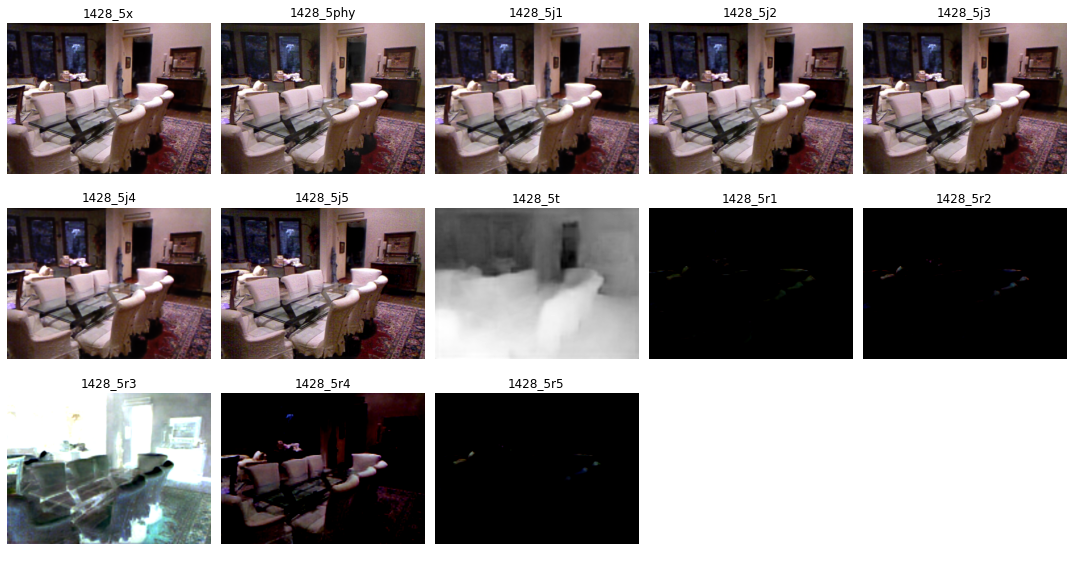

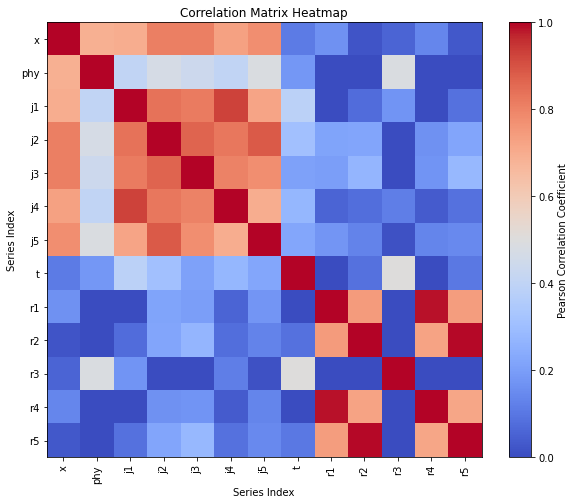

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


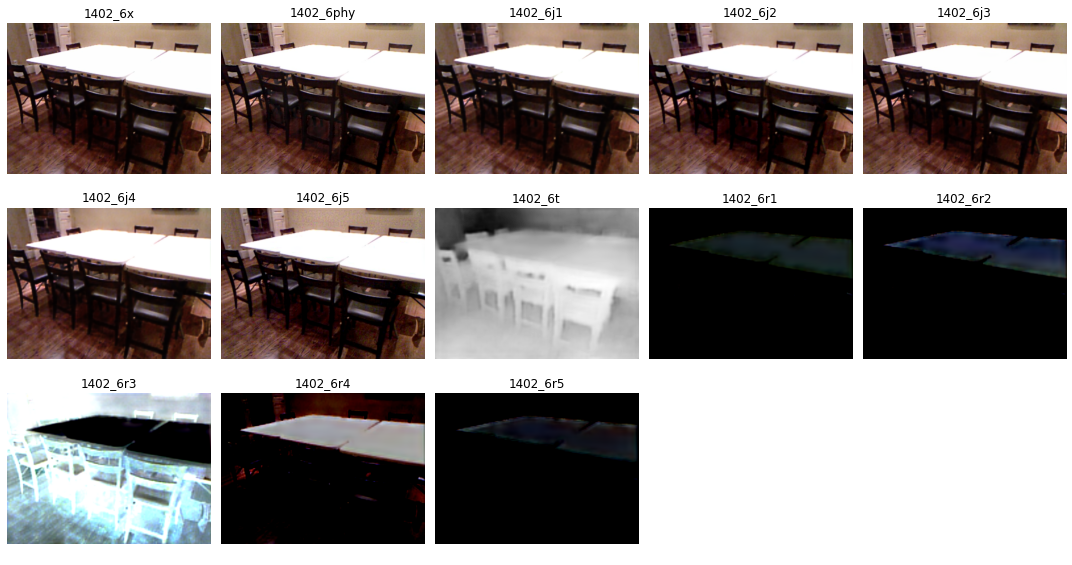

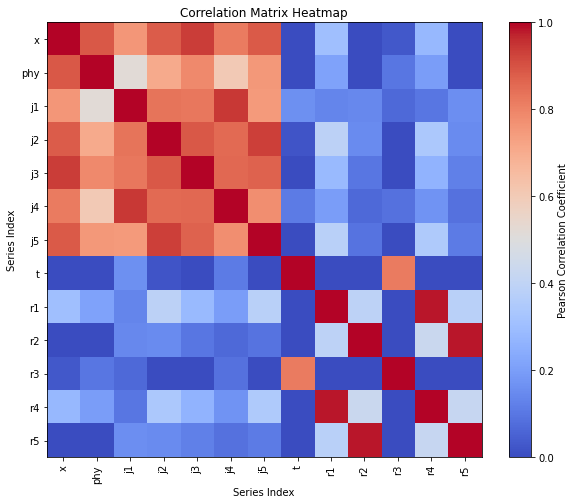

In [4]:
with torch.no_grad():
    for data in val_loader:
        haze, gt, fs = data

        haze = haze.cuda()
        gt = gt.cuda()

        #x_fusion, x_phy, x_j1, x_j2, x_j3, x_j4, x_j5, t = net(haze)
        r_l = net(haze)
        print(len(r_l))
        print(len(r_l[0]))
        for i in range(len(fs)):
            name = fs[i]
            titles = ['x', 'phy', 'j1', 'j2', 'j3', 'j4', 'j5', 't', 'r1', 'r2', 'r3', 'r4', 'r5']
            fig, axes = plt.subplots(3, 5, figsize=(15, 8))
            axes = axes.flatten()
            imgs = [a[i] for a in r_l]
            # 显示每个图像
            # for img, title, ax in zip(imgs, titles, axes):
            #     ax.imshow(img.cpu().numpy().transpose([1, 2, 0]))
            #     ax.set_title(name+title)
            #     ax.axis('off')
            for b, ax in enumerate(axes.flat):
                if b < len(imgs):
                    ax.imshow(imgs[b].cpu().numpy().transpose([1, 2, 0]), cmap='gray')
                    ax.set_title(name+titles[b])
                    ax.axis('off')  # 如果需要显示轴，可以保持'on'
                else:
                    ax.axis('off')  # 隐藏多余的子图
            plt.tight_layout()
            plt.show()
        

        # loss = criterion(dehaze, gt)
        # loss_record.update(loss.item(), haze.size(0))
        #for i in range(len(haze)):
            #r = dehaze[i].cpu().numpy().transpose([1, 2, 0])  # data range [0, 1]
            g = gt[i].cpu().numpy().transpose([1, 2, 0])
            correlation_matrix = np.zeros((len(imgs), len(imgs)))
            for j in range(len(imgs)):
                for k in range(len(imgs)):
                    img_j = imgs[j].cpu().numpy().transpose([1, 2, 0])
                    img_k = imgs[k].cpu().numpy().transpose([1, 2, 0])
                    
                    diff_j = img_j - g
                    diff_k = img_k - g
                    
                    # 将差异矩阵展平为一维向量
                    diff_j_flat = diff_j.flatten()
                    diff_k_flat = diff_k.flatten()
                    
                    # 计算相关性系数
                    correlation = np.corrcoef(diff_j_flat, diff_k_flat)[0, 1]
                    correlation_matrix[j, k] = correlation
            plt.figure(figsize=(10, 8))
            plt.imshow(correlation_matrix, cmap='coolwarm', vmin=0, vmax=1)
            plt.colorbar(label='Pearson Correlation Coefficient')
            plt.title('Correlation Matrix Heatmap')
            plt.xlabel('Series Index')
            plt.ylabel('Series Index')
            plt.xticks(np.arange(len(titles)), titles, rotation=90)
            plt.yticks(np.arange(len(titles)), titles)
            plt.show()

                    

            # psnr = peak_signal_noise_ratio(g, r)
            # ssim = structural_similarity(g, r, win_size=3, data_range=1, multichannel=True,
            #                                 gaussian_weights=True, sigma=1.5, use_sample_covariance=False)
            # ciede2000 = deltaE_ciede2000((g * 255).astype(int), (r * 255).astype(int)).mean()
            # psnr_record.update(psnr)
            # ssim_record.update(ssim)
            # ciede2000s.update(ciede2000)

        break


torch.Size([1, 3, 2516, 3873])


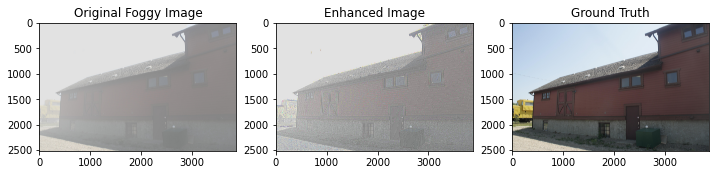

In [9]:
import torch
import torch.nn.functional as F

def local_contrast_enhancement(x, kernel_size=15):
    channels = x.shape[1]
    
    # 均值滤波器
    mean_filter = torch.ones((channels, 1, kernel_size, kernel_size), device=x.device) / (kernel_size ** 2)
    
    # 计算局部均值
    local_mean = F.conv2d(x, mean_filter, padding=kernel_size // 2, groups=channels)
    
    # 计算局部方差
    local_var = F.conv2d(x ** 2, mean_filter, padding=kernel_size // 2, groups=channels) - local_mean ** 2
    local_var = local_var.clamp(min=1e-6)
    
    # 计算标准差
    stddev = torch.sqrt(local_var)
    
    # 增强对比度
    x_enhanced = (x - local_mean) / (stddev + 1e-6)
    
    return 0.1*x_enhanced+x


def equalizeHist(image_tensor):
    # 分别对每个通道进行直方图均衡化
    equalized_channels = []
    for channel in range(image_tensor.shape[0]):
        channel_tensor = image_tensor[channel, :, :]
        
        # 计算直方图
        hist = torch.histc(channel_tensor, bins=256, min=channel_tensor.min(), max=channel_tensor.max())
        
        # 计算累积分布函数
        cdf = hist.cumsum(dim=0)
        
        # 归一化累积分布函数
        cdf = (cdf - cdf.min()) * 255 / (cdf.max() - cdf.min())
        
        # 对当前通道进行直方图均衡化
        equalized_channel = torch.gather(cdf.to(torch.int64), 0, channel_tensor.to(torch.int64).reshape(-1)).float()
        equalized_channel = equalized_channel.view(channel_tensor.shape)
        equalized_channels.append(equalized_channel)
    
    # 合并所有通道
    equalized_image_tensor = torch.stack(equalized_channels, dim=1)
    
    return equalized_image_tensor


# 示例：加载和处理图像
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# 加载图像并转换为张量
image_path = '/mnt/data/HazeRD/data/simu/IMG_7033_100.jpg'
gt_path = '/mnt/data/HazeRD/data/img/IMG_7033_RGB.jpg'
image = Image.open(image_path).convert('RGB')
gt = Image.open(gt_path).convert('RGB')
transform = transforms.Compose([
    transforms.ToTensor(),
])
image_tensor = transform(image).unsqueeze(0)  # 增加批次维度
# image_c = np.array(image, dtype='float32').transpose([2,0,1])
# # 将图片矩阵转换为pytorch tensor,并适配卷积输入的要求
# image_c= torch.from_numpy(image_c)
# 进行局部对比度增强
kernel_size = 15  # 选择合适的卷积核大小
enhanced_image_tensor = local_contrast_enhancement(image_tensor, kernel_size=kernel_size)
#enhanced_image_tensor = equalizeHist(image_c)
print(enhanced_image_tensor.shape)
# 转换回图像格式以便显示
enhanced_image = transforms.ToPILImage()(enhanced_image_tensor.squeeze(0))

# 显示原始图像和增强后的图像
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title('Original Foggy Image')
plt.imshow(image)

plt.subplot(1, 3, 2)
plt.title('Enhanced Image')
plt.imshow(enhanced_image)
plt.subplot(1, 3, 3)
plt.title('Ground Truth')
plt.imshow(gt)
plt.show()


In [ ]:
import numpy as np
gt = np.array(gt)
enhanced_image = np.array(enhanced_image)
print(gt.shape)
print(enhanced_image.shape)


(2516, 3873, 3)
(2516, 3873, 3)


In [ ]:
from skimage.color import deltaE_ciede2000, rgb2lab
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
#gt = Image.open(gt_path).convert('RGB')
labr = rgb2lab(enhanced_image)
labg = rgb2lab(gt)
psnr = peak_signal_noise_ratio(gt, enhanced_image)
ssim = structural_similarity(gt, enhanced_image, win_size=3, data_range=1, multichannel=True,
                                gaussian_weights=True, sigma=1.5, use_sample_covariance=False, channel_axis=-1)
ciede2000 = deltaE_ciede2000(labr, labg).mean()
print(f'psnr:{psnr} ssim:{ssim} ciede2000:{ciede2000}')

psnr:17.355515322605527 ssim:0.30661383684559285 ciede2000:12.222242367373624


0.15

psnr:10.504723863809327 ssim:0.20722896933226975 ciede2000:25.79422742090788

0.1
psnr:10.891625516357218 ssim:0.24498790510616675 ciede2000:25.054658610594682

### ohaze

In [1]:
import os

import numpy as np
import torch
from torch import nn
from torchvision import transforms
from PIL import Image
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset,DataLoader
from tools.utils import AvgMeter, check_mkdir, sliding_forward
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from skimage.color import deltaE_ciede2000, rgb2lab
import datetime
from tools.config import OHAZE_ROOT
from datasets import OHazeDataset
import warnings
# 忽略所有警告
warnings.filterwarnings("ignore")
to_tensor = ToTensor()

/root/miniconda3/envs/myconda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from model_change import DM2FNet_woPhy
import torch
net = DM2FNet_woPhy().cuda()
net.load_state_dict(torch.load('/root/DM2F-Net-master/ckpt/O-Haze/iter_2000_loss_0.05329_lr_0.000000.pth'))
net.eval()
val_dataset = OHazeDataset(OHAZE_ROOT, 'val')
val_loader = DataLoader(val_dataset, batch_size=1)
import matplotlib.pyplot as plt
net.eval()

loss_record = AvgMeter()
psnr_record, ssim_record, ciede2000s = AvgMeter(), AvgMeter(), AvgMeter()
criterion = nn.L1Loss().cuda()

14
1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


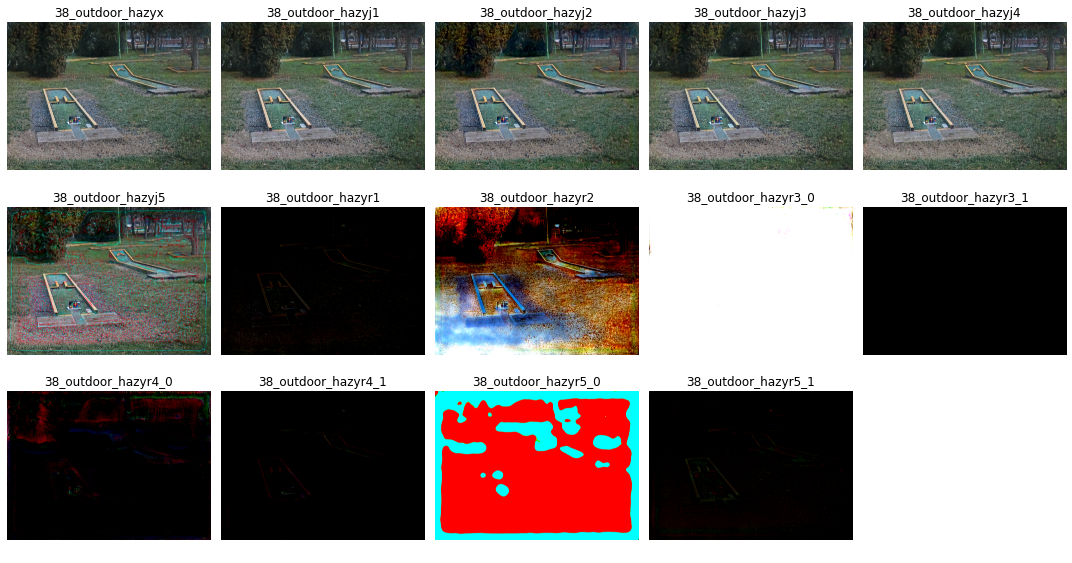

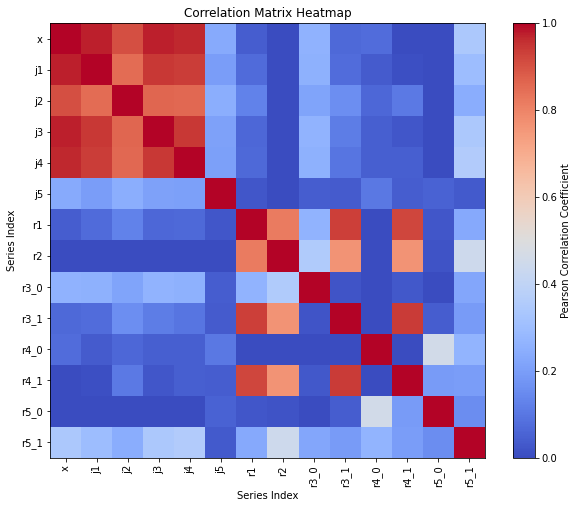

In [3]:
with torch.no_grad():
    for data in val_loader:
        haze, gt, fs = data

        haze = haze.cuda()
        gt = gt.cuda()

        #x_fusion, x_phy, x_j1, x_j2, x_j3, x_j4, x_j5, t = net(haze)
        r_l = net(haze)
        print(len(r_l))
        print(len(r_l[0]))
        for i in range(len(fs)):
            name = fs[i]
            titles = ['x', 'j1', 'j2', 'j3', 'j4', 'j5', 'r1', 'r2', 'r3_0', 'r3_1', 'r4_0', 'r4_1', 'r5_0', 'r5_1']
            fig, axes = plt.subplots(3, 5, figsize=(15, 8))
            axes = axes.flatten()
            imgs = [a[i] for a in r_l]
            # 显示每个图像
            # for img, title, ax in zip(imgs, titles, axes):
            #     ax.imshow(img.cpu().numpy().transpose([1, 2, 0]))
            #     ax.set_title(name+title)
            #     ax.axis('off')
            for b, ax in enumerate(axes.flat):
                if b < len(imgs):
                    ax.imshow(imgs[b].cpu().numpy().transpose([1, 2, 0]), cmap='gray')
                    ax.set_title(name+titles[b])
                    ax.axis('off')  # 如果需要显示轴，可以保持'on'
                else:
                    ax.axis('off')  # 隐藏多余的子图
            plt.tight_layout()
            plt.show()
        

        # loss = criterion(dehaze, gt)
        # loss_record.update(loss.item(), haze.size(0))
        #for i in range(len(haze)):
            #r = dehaze[i].cpu().numpy().transpose([1, 2, 0])  # data range [0, 1]
            g = gt[i].cpu().numpy().transpose([1, 2, 0])
            correlation_matrix = np.zeros((len(imgs), len(imgs)))
            for j in range(len(imgs)):
                for k in range(len(imgs)):
                    img_j = imgs[j].cpu().numpy().transpose([1, 2, 0])
                    img_k = imgs[k].cpu().numpy().transpose([1, 2, 0])
                    
                    diff_j = img_j - g
                    diff_k = img_k - g
                    
                    # 将差异矩阵展平为一维向量
                    diff_j_flat = diff_j.flatten()
                    diff_k_flat = diff_k.flatten()
                    
                    # 计算相关性系数
                    correlation = np.corrcoef(diff_j_flat, diff_k_flat)[0, 1]
                    correlation_matrix[j, k] = correlation
            plt.figure(figsize=(10, 8))
            plt.imshow(correlation_matrix, cmap='coolwarm', vmin=0, vmax=1)
            plt.colorbar(label='Pearson Correlation Coefficient')
            plt.title('Correlation Matrix Heatmap')
            plt.xlabel('Series Index')
            plt.ylabel('Series Index')
            plt.xticks(np.arange(len(titles)), titles, rotation=90)
            plt.yticks(np.arange(len(titles)), titles)
            plt.show()


        break


### 数据增强尝试

In [42]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 读取图像
I = cv2.imread(image_path)
I = transforms.ToTensor()(I)

# 分通道
R = I[:,:,0]
G = I[:,:,1]
B = I[:,:,2]

# 对RGB分量进行全局直方图均衡化
IR = cv2.equalizeHist(R)
IG = cv2.equalizeHist(G)
IB = cv2.equalizeHist(B)

# 均衡化后的图像
I2 = cv2.merge((IR, IG, IB))

# 显示原始图像和均衡化后的图像
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(I, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(I2, cv2.COLOR_BGR2RGB))
plt.title('Enhanced Image')

plt.show()


error: OpenCV(4.5.5) :-1: error: (-5:Bad argument) in function 'equalizeHist'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'


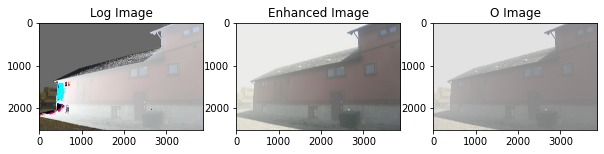

In [71]:
def clahe(image):
    b, g, r = cv2.split(image)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    b = clahe.apply(b)
    g = clahe.apply(g)
    r = clahe.apply(r)
    image_clahe = cv2.merge([b, g, r])
    return image_clahe

def replaceZeroes(data):
    min_nonzero = min(data[np.nonzero(data)])
    data[data == 0] = min_nonzero
    return data

def MSR(img, scales):
    weight = 1 / 3.0
    scales_size = len(scales)
    h, w = img.shape[:2]
    log_R = np.zeros((h, w), dtype=np.float32)

    for i in range(scales_size):
        img = replaceZeroes(img)
        L_blur = cv2.GaussianBlur(img, (scales[i], scales[i]), 0)
        L_blur = replaceZeroes(L_blur)
        dst_Img = cv2.log(img/255.0)
        dst_Lblur = cv2.log(L_blur/255.0)
        dst_Ixl = cv2.multiply(dst_Img, dst_Lblur)
        log_R += weight * cv2.subtract(dst_Img, dst_Ixl)

    dst_R = cv2.normalize(log_R,None, 0, 255, cv2.NORM_MINMAX)
    log_uint8 = cv2.convertScaleAbs(dst_R)
    return log_uint8
def MSR_image(image):
    scales = [15, 101, 301]  # [3,5,9]
    b_gray, g_gray, r_gray = cv2.split(image)
    b_gray = MSR(b_gray, scales)
    g_gray = MSR(g_gray, scales)
    r_gray = MSR(r_gray, scales)
    result = cv2.merge([b_gray, g_gray, r_gray])
    return result
image_path = '/mnt/data/HazeRD/data/simu/IMG_7033_100.jpg'
I = cv2.imread(image_path)
image_float = I.astype(np.float32) / 255.0

# 对每个像素点应用指数变换
exp_image = np.exp(image_float)

# 将结果缩放回 [0, 255] 范围并转换为 uint8 类型
exp_image_uint8 = (exp_image * 255).astype(np.uint8)

I2 = MSR_image(I)
plt.figure(figsize=(10, 6))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(exp_image_uint8, cv2.COLOR_BGR2RGB))
plt.title('Log Image')

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(I2, cv2.COLOR_BGR2RGB))
plt.title('Enhanced Image')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(I, cv2.COLOR_BGR2RGB))
plt.title('O Image')

plt.show()